# Классификация текстов

In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import warnings

warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30665,41515,86467,"Concord, MA",10-04-2020,POULTRY INDUSTRYÃÂS DELAYED COVID-19 RESPONS...,Extremely Negative
10006,15951,60903,The Bay State,21-03-2020,Every time I go out into the pandemic and try ...,Extremely Negative
3229,7704,52656,"Miami, Fl",18-03-2020,The line at the grocery store can be long amid...,Positive
11401,17624,62576,LA2Chicago.No place like home.,21-03-2020,"Wtf, #TraderJoes. Why on earth wonÃÂt u let ...",Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



##  Подготовка

In [ ]:
df['Sentiment'] = df['Sentiment'].str.contains('Positive', case=False).astype(int) # ищет в каждой строке слово Positive, если оно есть, то заменяет значение на True, потом преобразовывает в 1
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
16953,24432,69384,NaN,25-03-2020,Egg prices are skyrocketing because of coronav...,0
32616,43920,88872,"Washington, DC",13-04-2020,The most visible impacts of coronavirus are in...,1
13365,20017,64969,On Your Timeline,22-03-2020,Letter Carriers Say the Postal Service Pressur...,0
30356,41101,86053,United States,10-04-2020,Strange times when toilet paper &amp; Lysol ar...,0


In [ ]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

Классы можно назвать сбалансированными, поскольку они относятся как 6:5

In [ ]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
df[df.isna().any(axis=1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
11,3813,48765,NaN,16-03-2020,ADARA Releases COVID-19 Resource Center for Tr...,1
16,3821,48773,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,1
17,3822,48774,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,1
...,...,...,...,...,...,...
33431,44938,89890,NaN,14-04-2020,Hello everyone \r\r\nPlease share this in your...,1
33437,44947,89899,NaN,14-04-2020,UV light Sterilizer Sanitizer for your mask an...,1
33440,44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,0


In [ ]:
df['Location'].fillna('Unknown', inplace=True) # заполняем пропуски
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1
33440,44950,89902,Unknown,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,Unknown,14-04-2020,Response to complaint not provided citing COVI...,0
33442,44953,89905,Unknown,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split (df, test_size = 0.3,  random_state=0)


## Токенизация

Построим словарь на основе обучающей выборки и посчитаем количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
tokens = dict()
tokenized_words = train['OriginalTweet'].apply(lambda x: x.lower().split())
for words in tokenized_words:
  for w in words:
    tokens[w] = tokens.get(w, 0) + 1

In [ ]:
len(tokens)

79755

Выведем 10 самых популярных токенов с количеством встреч каждого из них.

In [ ]:
sorted_tokens = sorted(tokens.items(), key = lambda x: -x[1])
top = sorted_tokens[:10]
print(*top)

('the', 26815) ('to', 23373) ('and', 14684) ('of', 13012) ('a', 11737) ('in', 11198) ('for', 8566) ('#coronavirus', 8223) ('is', 7383) ('are', 7050)


**Вывод:** Наиболее популярные слова - предлоги и глаголы-связки из-за грамматических особенностей английского языка и необходимости добавления их в каждое предложение. Также часто встречается хештэг #coronavirus, скорее всего люди писали на злободневную тему во время пандемии

Удалим стоп-слова из словаря и выведем новый топ-10 токенов (и количество встреч) по популярности.

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)
stop_words = set(stopwords.words("english"))
filt_tokens = {}
for key, val in sorted_tokens:
  if key not in stop_words:
    filt_tokens[key] = val
sorted_filt_tokens = sorted(filt_tokens.items(), key = lambda x: -x[1])
print (*sorted_filt_tokens[:10])

('#coronavirus', 8223) ('prices', 3891) ('food', 3820) ('grocery', 3469) ('supermarket', 3288) ('people', 3175) ('covid-19', 3173) ('store', 3155) ('#covid19', 2471) ('&amp;', 2314)


**Вывод:** Теперь появляется больше информации о том, что писали люди. Основные темы касаются пандемии: среди наиболее популярных слов несколько раз повторяется ковид в разных формулировках. А также связанные с ним слова: цены, еда, супермаркеты, магазины, люди. Все передает атмосферу того периода...

Также выведем 20 самых непопулярных слов

In [ ]:
sorted_filt_tokens_min = sorted(filt_tokens.items(), key = lambda x: x[1])
print (*sorted_filt_tokens_min[:20])

('https://t.co/1m881cwfuv', 1) ('happy..', 1) ('https://t.co/z0intks34x', 1) ('mnuchinã\x82â\x92s', 1) ('brink.', 1) ('https://t.co/jmobv8z0u0', 1) ("university's", 1) ('teaching.)', 1) ('@catholicpres', 1) ('@catholicuniv', 1) ('https://t.co/evqby035wf', 1) ('https://t.co/riqrhxxeim', 1) ('@@ballardspahrll', 1) ('#aca', 1) ('easier...take', 1) ('ã\x82â\x93necessaryã\x82â\x94', 1) ('https://t.co/0fmsmlgepm', 1) ('husted:', 1) ('irishman', 1) ('#happystpatricksday!', 1)


**Вывод:** Среди наименее популярных слов те, которые записаны с какими-то символами (восклицательный знак, кавычки, собака, хэштэг) либо же это какие-то ссылки и аббревиатуры. Работать с ними бесполезно, потому что они не несут никакой смысловой нагрузки


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Применим его и посмотрим на топ-10 популярных слов.

In [ ]:
#TODO
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
tokens ={}
tokenized_words = train['OriginalTweet'].apply(lambda x: tw.tokenize(x))
for words in tokenized_words:
  for w in words:
    tokens[w] = tokens.get(w, 0) + 1
sorted_tokens = sorted(tokens.items(), key = lambda x: -x[1])
sorted_tokens[:10]
#top = sorted_tokens[:10]
#print(*top)

[('the', 24337),
 ('.', 24118),
 ('to', 22933),
 (',', 17571),
 ('and', 14354),
 ('of', 12904),
 ('a', 11045),
 ('in', 10573),
 ('?', 9524),
 ('for', 8228)]

**Вывод:** Состав самых популярных слов почти не изменился, увеличилось лишь количество и добавились знаки препинания - точка и запятая. Это происходит из-за того, что TweetTokenizer выделяет смайлики, хештэги и другие символы в отдельные токены, поэтому они не слипаются со словами. Из-за этого предлоги без знака препинания и с ним считаются как одно слово, очищенное от знака.

Удалим из словаря стоп-слова и пунктуацию, посмотрим на новый топ-10 слов с количеством встреч

In [ ]:
#TODO
from string import punctuation
noise = stopwords.words("english") + list(punctuation)

#filt_tokens = {}
for word in list(tokens.keys()):
    if word in noise:
        del tokens[word]
sorted_filt_tokens = sorted(tokens.items(), key = lambda x: -x[1])
print (*sorted_filt_tokens[:10])

('Â', 7415) ('\x82', 7311) ('19', 7167) ('#coronavirus', 7143) ('I', 5235) ('\x92', 4372) ('prices', 4281) ('COVID', 4218) ('food', 3795) ('store', 3691)


**Вывод:** Как и раньше есть слова, относящиеся к ковиду. Помимо этого, есть и что-то не похожее на слова: Â, \х82,

Удалим из словаря токены из одного символа

Выведем топ-10 самых популярных и топ-20 непопулярных слов.

In [ ]:
for word in list(tokens.keys()):
  if len(word) == 1 and ord(word) >= 128:
        del tokens[word]
sorted_filt_tokens_full = sorted(tokens.items(), key = lambda x: -x[1])
print ('top-10 pop:')
print (*sorted_filt_tokens_full[:10])

top-10 pop:
('19', 7167) ('#coronavirus', 7143) ('I', 5235) ('prices', 4281) ('COVID', 4218) ('food', 3795) ('store', 3691) ('supermarket', 3373) ('grocery', 3083) ('people', 3047)


In [ ]:
sorted_filt_tokens_min = sorted(filt_tokens.items(), key = lambda x: x[1])
print ('top-20 unpop:')
print (*sorted_filt_tokens_min[:20])

top-20 unpop:
('https://t.co/1m881cwfuv', 1) ('happy..', 1) ('https://t.co/z0intks34x', 1) ('mnuchinã\x82â\x92s', 1) ('brink.', 1) ('https://t.co/jmobv8z0u0', 1) ("university's", 1) ('teaching.)', 1) ('@catholicpres', 1) ('@catholicuniv', 1) ('https://t.co/evqby035wf', 1) ('https://t.co/riqrhxxeim', 1) ('@@ballardspahrll', 1) ('#aca', 1) ('easier...take', 1) ('ã\x82â\x93necessaryã\x82â\x94', 1) ('https://t.co/0fmsmlgepm', 1) ('husted:', 1) ('irishman', 1) ('#happystpatricksday!', 1)


**Вывод:** Топы, полученные с помощью Tweet tokenizer имеют почти тот же состав, только нет непонятных симоволов, не похожих на слова. При этом, например, есть символ I, который не особо информативен. Топ лучше тем, что информативных слов теперь больше, но все равно остаются ссылки и слова с другими символами, например, собаками и хэштэгами


Выведем топ-10 популярных хештегов с количеством встреч.

In [ ]:
hash = {}
for key, val in sorted_filt_tokens_full:
  if '#' in key:
    hash[key] = val
sorted_hash = sorted(hash.items(), key = lambda x: -x[1])
print ('top-10 #:')
print (*sorted_hash[:10])



top-10 #:
('#coronavirus', 7143) ('#COVID19', 1844) ('#Covid_19', 1463) ('#Coronavirus', 1281) ('#COVID2019', 927) ('#toiletpaper', 657) ('#covid19', 568) ('#COVID', 542) ('#CoronaCrisis', 426) ('#CoronaVirus', 351)


**Вывод:** Все популяоные хэштэги снова на злободневную тему - различные упоминания ковида, пандемии и вытекающих из этого последствий.

То же самое проделаем для ссылок на сайт https://t.co

In [ ]:
ref = {}
for key, val in sorted_filt_tokens_full:
  if key.startswith('https://t.co'):
    ref[key] = val
sorted_ref = sorted(ref.items(), key = lambda x: -x[1])
print ('top-10 ref:')
print (*sorted_ref[:10])


top-10 ref:
('https://t.co/oXA7SWtoNd', 5) ('https://t.co/gP3EusapL8', 4) ('https://t.co/DefTruI1PfÃ\x82Â', 3) ('https://t.co/WrLHYzIzAA', 3) ('https://t.co/kuwIpF1KQW', 3) ('https://t.co/zjNRx6dKKN', 3) ('https://t.co/3GBBDpdjat', 3) ('https://t.co/e2ZNXajPre', 3) ('https://t.co/CATKegAyOY', 3) ('https://t.co/G63RP042HO', 3)


**Вывод:** Популярность конкретный ссылок гораздо меньше и не сопоставима с популярностью хэштэгов. Скорее всего, информация о ссылке на конкретную страницу не будет информативна

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  tw = TweetTokenizer()
  text = text.lower()
  tokens = tw.tokenize (text)
  tok = []
  noise = stopwords.words("english") + list(punctuation)
  #tokens = set(tokens) - set(noise)
  for token in tokens:
    if (len(token) ==1 and ord(token) >= 128)  or  token.startswith('https://t.co') or token  in noise:
      tok.append(token)

  return set(tokens) - set(tok)

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

{'#sampletext', '@sample_text', 'sample', 'text'}

##  Векторизация текстов

Обучим CountVectorizer с использованием custom_tokenizer в качестве токенайзера.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
vector = cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))
#vector.toarray()

45308


**Вывод:** Полученный словарь оказался меньше почти в 2 раза.

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Применим обученный CountVectorizer для векторизации данного текста, и попытаемся определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0)

In [ ]:
ind = 9023
tweet = train.iloc[ind]['OriginalTweet']
tweet_cv = cv.transform ([tweet])
#tweet_cv = pd.DataFrame(tweet_cv.toarray(), columns=cv.get_feature_names_out())
print(tweet_cv)
#print(sorted(cv.vocabulary_.items(), key = lambda x: -x[1])) # количество токенов, которые есть в данном тексте, среди всех текстов

  (0, 1833)	1
  (0, 2046)	1
  (0, 16658)	1
  (0, 20553)	1
  (0, 26665)	1
  (0, 27042)	1
  (0, 27233)	1
  (0, 31579)	1
  (0, 34079)	1
  (0, 34688)	1
  (0, 35257)	1
  (0, 36413)	1
  (0, 37229)	1
  (0, 39919)	1


In [ ]:
w_cv = {} # вытащим токены и их веса из объекта csr_matrix
for i in range (len(tweet_cv.indices)):
  w_cv[cv.get_feature_names_out()[(tweet_cv.indices[i])]] = tweet_cv.data[i]
for key,val in sorted(w_cv.items(), key = lambda x: -x[1]):
  print (f'{key}: {val}')

#coronavirusoutbreak: 1
#covid2019: 1
@skynews: 1
brainless: 1
ffs: 1
food: 1
france: 1
lets: 1
nice: 1
one: 1
panic: 1
ppl: 1
queueing: 1
show: 1


**Вывод:**  Мы получили, что все слова в данном тексте встречаются ровно 1 раз. Такой информации не достаточно для того, чтобы определить важность и неважность токенов

Теперь применим TfidfVectorizer и  определим самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
X = tfidf_vec.fit_transform(train['OriginalTweet'])
tweet_t = tfidf_vec.transform([tweet])
w_t = {}  # вытащим токены и их веса из объекта csr_matrix
for i in range (len(tweet_t.indices)):
  w_t[tfidf_vec.get_feature_names_out()[(tweet_t.indices[i])]] = tweet_t.data[i]
for key,val in sorted(w_t.items(), key = lambda x: -x[1]):
  print (f'{key}: {val}')

brainless: 0.3867641170466375
queueing: 0.35434556333216544
ffs: 0.3244741764513268
france: 0.32047314046539654
@skynews: 0.31042634466284263
lets: 0.30121070136861045
ppl: 0.2550064610386691
nice: 0.2542729176022132
show: 0.24406492401820118
#coronavirusoutbreak: 0.22584265007428544
#covid2019: 0.16825192939361902
one: 0.16306722855395073
panic: 0.14759470306326164
food: 0.11328893069250721


**Вывод:** теперь же все веса принадлежат от 0 до 1. Тогда наиболее значимым будет токен, имеющий наибольший по модулю вес. У нас это слово **brainless**, оно редко встречается в других текстах, поэтому для данного твита имеет большой вес. Обратная логика для наименее важного слова **food**, которое часто встречается в других текстах.

Действительно, слово **brainless** опредляет негативный характер всего твита, значит, логика в весах есть

Найдем какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен.

Явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)].sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
11808,18128,63080,"Brighton, England",21-03-2020,#CoronaCrisis #cornavirusuk #HelpEachOther can...,1
11382,17603,62555,"Greenwich, London",21-03-2020,Back in Blighty and wow how things have change...,1
469,4365,49317,TaÃÂ¯wan,16-03-2020,#COVID19 19 A friend of mine in the US works a...,1
2734,7106,52058,UK,18-03-2020,"Crude Oil is now worth 2001 prices, $20 a barr...",1
8001,13523,58475,United Kingdom,20-03-2020,"Today, we'd love to say a big thank you to all...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
28505,38773,83725,"Truro, Nova Scotia",08-04-2020,We're officially up &amp; running with product...,1
8234,13803,58755,Unknown,20-03-2020,"Do something amazing tomorrow, save lives by d...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
32078,43261,88213,"Brooklyn, NY",13-04-2020,Late at night 2 00 and is amazing how on every...,1


In [ ]:
train.loc[4583]

UserName                                                      9362
ScreenName                                                   54314
Location                                          Moulton, England
TweetAt                                                 19-03-2020
OriginalTweet    Hearing so many stories of NHS heroes Teachers...
Sentiment                                                        1
Name: 4583, dtype: object

In [ ]:
ind = 4583
tw = train.loc[ind]['OriginalTweet']
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
vector = tfidf_vec.fit_transform(train['OriginalTweet'])
X = tfidf_vec.transform([tw])
w_t = {}  # вытащим токены и их веса из объекта csr_matrix
for i in range (len(X.indices)):
  w_t[tfidf_vec.get_feature_names_out()[(X.indices[i])]] = X.data[i]
for key,val in sorted(w_t.items(), key = lambda x: -x[1]):
  print (f'{key}: {val}')

superstar: 0.36040813259991145
briefly: 0.353455795999061
equally: 0.3379944870839889
walked: 0.2873115033695429
stories: 0.27747989165622566
hearing: 0.2766229504309899
absolute: 0.2766229504309899
teachers: 0.2608802212001542
amazing: 0.24395210530514877
heroes: 0.22777802274567863
nhs: 0.22271560074470118
today: 0.16760195326727953
many: 0.16635943824006097
workers: 0.14772674929367088
supermarket: 0.10819401755340155


**Вывод:** по положительному токену *amazing* был найден твит. В нем наибольший вес имеют слова *superstar*, *briefly*, *equally*. Они тоже имеют положительный окрас, что и позволяет отнести твит к положительным

##  Обучение первых моделей

Применим оба векторайзера для получения матриц с признаками текстов.  Выделим целевую переменную.

In [ ]:
cv_train = cv.fit_transform(train['OriginalTweet'])
t_train = tfidf_vec.fit_transform(train['OriginalTweet'])
target_train = train['Sentiment']
target_test = test['Sentiment']

Обучим логистическую регрессию на векторах из обоих векторайзеров. Посчитаем долю правильных ответов на обучающих и тестовых данных.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cv_test = cv.transform(test['OriginalTweet'])
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(cv_train, target_train)
pred_cv_train = clf.predict(cv_train)
pred_cv = clf.predict(cv_test)
cv_accuracy = accuracy_score(target_test, pred_cv)
cv_accuracy_train = accuracy_score(target_train, pred_cv_train)
print (f'CountVectorizer test: {cv_accuracy}')
print (f'CountVectorizer train: {cv_accuracy_train}')

CountVectorizer test: 0.8660554116005581
CountVectorizer train: 0.982913284920974


In [ ]:
t_test = tfidf_vec.transform(test['OriginalTweet'])
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(t_train, target_train)
pred_t = clf.predict(t_test)
pred_t_train = clf.predict(t_train)
t_accuracy_train = accuracy_score(target_train, pred_t_train)
t_accuracy = accuracy_score(target_test, pred_t)
print (f'TfidfVectorizer test: {t_accuracy}')
print (f'TfidfVectorizer train: {t_accuracy_train}')

TfidfVectorizer test: 0.8527008172214471
TfidfVectorizer train: 0.924647586501495


**Вывод:** наилучший результат показал CountVectorizer. При этом обе модели обладают высокой долей правильных ответов.

## Стемминг

Для уменьшения словаря можно использовать стемминг.

Модифицируем написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучим Count- и Tfidf- векторайзеры.

In [ ]:
from nltk.stem.snowball import SnowballStemmer
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  tokenized_words = [w for w in custom_tokenizer(text)]
  tokens = [stemmer.stem(w) for w in tokenized_words]
  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['@sample_text', 'stem', 'check', 'sampl', 'text', '#sampletext', 'word', 'ad']

In [ ]:
cv_stem = CountVectorizer(tokenizer = custom_stem_tokenizer)
vector = cv_stem.fit_transform(train['OriginalTweet'])
print(len(cv_stem.vocabulary_))

36652


In [ ]:
tf_idf_stem = TfidfVectorizer(tokenizer = custom_stem_tokenizer )
vector = tf_idf_stem.fit_transform(train['OriginalTweet'])
print(len(tf_idf_stem.vocabulary_))

36652


**Вывод:** размер словаря стал еще меньше. Это логично, поскольку это стемминг своего рода фильтр, делающий из разных грамматических форм слова одинаковые токены

Обучим логистическую регрессию с использованием обоих векторайзеров.

In [ ]:
cv_train = cv_stem.fit_transform(train['OriginalTweet'])
cv_test = cv_stem.transform(test['OriginalTweet'])
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(cv_train, target_train)
pred_cv_train = clf.predict(cv_train)
pred_cv = clf.predict(cv_test)
cv_accuracy = accuracy_score(target_test, pred_cv)
cv_accuracy_train = accuracy_score(target_train, pred_cv_train)
print (f'CountVectorizer test: {cv_accuracy}')
print (f'CountVectorizer train: {cv_accuracy_train}')

CountVectorizer test: 0.8666533785130556
CountVectorizer train: 0.9692439128577531


In [ ]:
t_train = tf_idf_stem.fit_transform(train['OriginalTweet'])
t_test = tf_idf_stem.transform(test['OriginalTweet'])
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(t_train, target_train)
pred_t = clf.predict(t_test)
pred_t_train = clf.predict(t_train)
t_accuracy_train = accuracy_score(target_train, pred_t_train)
t_accuracy = accuracy_score(target_test, pred_t)
print (f'TfidfVectorizer test: {t_accuracy}')
print (f'TfidfVectorizer train: {t_accuracy_train}')

TfidfVectorizer test: 0.8567869244568467
TfidfVectorizer train: 0.9156770610850065


**Вывод:** качество моделей на тесте практически не изменилось, на трейне упало, значит, применять стемминг не имеет смысла

## Работа с частотами

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.




Подберем max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было).

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.3
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36651


**Вывод:** параметр получился небольшой, поскольку он отвечает за максимальную долю текстов, в которых встречается токен. Поэтому, чтобы отбросить 1 токен, нужно ставить небольшое значение параметра, ведь слова, встречающиеся почти в каждом предложении - stop words и punctuations уже были отброшены. Интуитивно, очень маловероятно, что какое-либо другое слово будет встречаться почти в каждом предложении.

Подберем min_df  в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было.

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=1.0,
                        min_df=0.000435
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


In [ ]:
CV = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.000435
                        )
cv_train = CV.fit_transform(train['OriginalTweet'])
cv_test = CV.transform(test['OriginalTweet'])
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(cv_train, target_train)
pred_cv_train = clf.predict(cv_train)
pred_cv = clf.predict(cv_test)
cv_accuracy = accuracy_score(target_test, pred_cv)
cv_accuracy_train = accuracy_score(target_train, pred_cv_train)
print (f'CountVectorizer test: {cv_accuracy}')
print (f'CountVectorizer train: {cv_accuracy_train}')

CountVectorizer test: 0.8652581223838948
CountVectorizer train: 0.9260145237078172


**Вывод:** параметр min_df должен быть очень маленьким, чтобы получить такой размер словаря, при этом качетсво не потерялось. Это говорит о том, что редко встречающиеся слова не влияют на обучение модели, поскольку они незначимы

В предыдущих заданиях признаки не скалировались. Отскалируем данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучим логистическую регрессию, посмотрим на качество и выведем `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
cv_train = scaler.fit_transform(cv_train)
cv_test = scaler.transform(cv_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(cv_train, target_train)
pred_cv_train = clf.predict(cv_train)
pred_cv = clf.predict(cv_test)
cv_accuracy = accuracy_score(target_test, pred_cv)
cv_accuracy_train = accuracy_score(target_train, pred_cv_train)
print (f'CountVectorizer test: {cv_accuracy}')
print (f'CountVectorizer train: {cv_accuracy_train}')

CountVectorizer test: 0.8424357185569065
CountVectorizer train: 0.9396838957710381


**Вывод:** качество немного упало относительно базовой модели

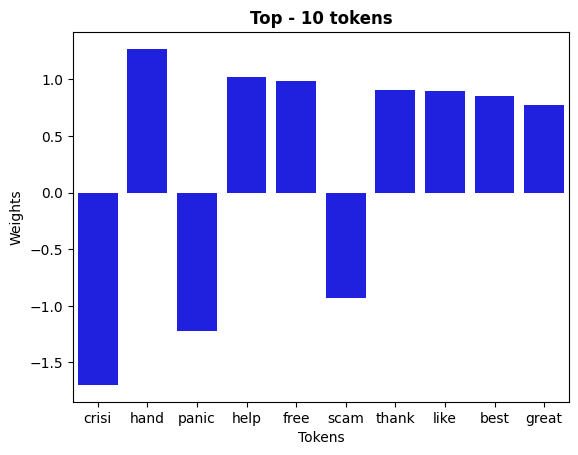

In [ ]:
coef = clf.coef_[0]
features = CV.get_feature_names_out()
token_weights = dict(zip(features, coef))
top10_tokens = []
top10_weights = []
for key, val in sorted(token_weights.items(), key = lambda x: -abs(x[1])):
  top10_tokens.append(key)
  top10_weights.append(val)
#print (top10_weights[:10])
#print (top10_tokens[:10])
sns.barplot(x=top10_tokens[:10], y=top10_weights[:10], color = 'b')
plt.xlabel('Tokens')
plt.ylabel('Weights')
plt.title('Top - 10 tokens', fontweight = 'bold')
plt.show()

**Вывод:** Полученные токены сильнее всего влияют на сентимент. Получилось вполне логично: слова паника, кризис, скам являются негативными и делают отзыв скорее негативным. И наоборот, такие слова как помощь, бесплатно, лучший, лайк делают добавляют в отзыв позитива.



## Другие признаки

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучим признаки UserName и ScreenName.

**Гипотеза:** данные признаки могут быть полезны, если один и тот же пользователь пишет твиты с одной окраской: только позитивные или негативные. Проверим это

In [ ]:
train.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
12177,18568,63520,??,22-03-2020,This whole COVID 19 panic buying and self quar...,0
32914,44274,89226,Unknown,13-04-2020,Things I miss about normal life:\r\r\n-Seeing ...,1
16673,24098,69050,"Bengaluru, India",24-03-2020,@nimmasuresh I am really appreciate your work...,1
21168,29616,74568,United States,01-04-2020,Warning from the @FTC: Want to get your #Coron...,1


In [ ]:
mean_target = train.groupby('UserName')['Sentiment'].mean() # Группируем по UserName и берем среднее в этих группах по целевой переменной
train['UserName'] = train['UserName'].replace(mean_target)
test['UserName'] = test['UserName'].replace(mean_target)
#len(train['UserName'])
#train['UserName'].shape

mean_target_Sn = train.groupby('ScreenName')['Sentiment'].mean() # Группируем по ScreenName и берем среднее в этих группах по целевой переменной
train['ScreenName'] = train['ScreenName'].replace(mean_target_Sn)
test['ScreenName'] = test['ScreenName'].replace(mean_target_Sn)

In [ ]:
un = np.expand_dims(train['UserName'], axis=1)
sn = np.expand_dims(train['ScreenName'], axis=1)
un_test = np.expand_dims(test['UserName'], axis=1)
sn_test = np.expand_dims(test['ScreenName'], axis=1)
# Объединение матрицы cv_train и массива user_name_array
cv_train_name = np.hstack((cv_train.toarray(), un))
cv_train_name = np.hstack((cv_train_name, sn))
cv_train_name
cv_test_name = np.hstack((cv_test.toarray(), un_test))
cv_test_name = np.hstack((cv_test_name, sn_test))

In [ ]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(cv_train_name, target_train)
pred_cv = clf.predict(cv_test_name)
cv_accuracy = accuracy_score(target_test, pred_cv)

pred_cv_train = clf.predict(cv_train_name)
cv_accuracy_train = accuracy_score(target_train, pred_cv_train)
print (f'CountVectorizer test: {cv_accuracy}')
print (f'CountVectorizer train: {cv_accuracy_train}')

CountVectorizer test: 0.5463424357185569
CountVectorizer train: 1.0


**Ответ:** качество на тесте упало, а трейн переобучился. Значит, признак все-таки бесполезен

Изучим признак TweetAt в обучающей выборке: преобразуем его к типу datetime и построем его гистограмму с разделением по цвету на основе целевой переменной.

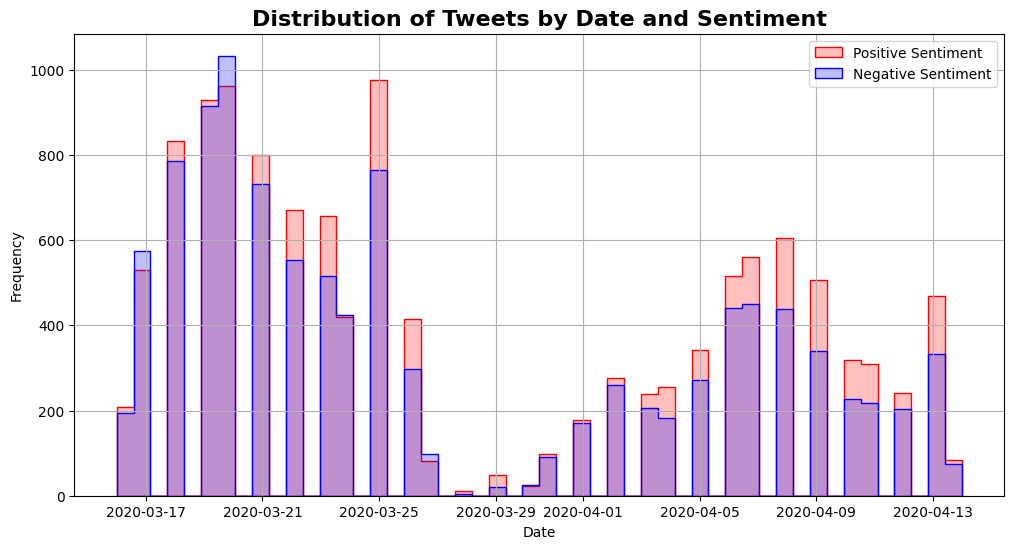

In [ ]:
train['TweetAt'] = pd.to_datetime(train["TweetAt"], format =  "%d-%m-%Y")
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', bins=50, element='step', palette=['blue', 'red'], legend=True)

plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Tweets by Date and Sentiment', fontweight = 'bold', fontsize = 16)
plt.legend(labels=['Positive Sentiment', 'Negative Sentiment'])
plt.grid()
plt.show()

**Вывод:** данный признак не информативен, поскольку во все даты были твиты как позитивного, так и негативного характера.


Поработаем с признаком Location в обучающей выборке.

In [ ]:
train['Location'].nunique()

7949

Построем гистограмму топ-10 по популярности местоположений (исключая Unknown)

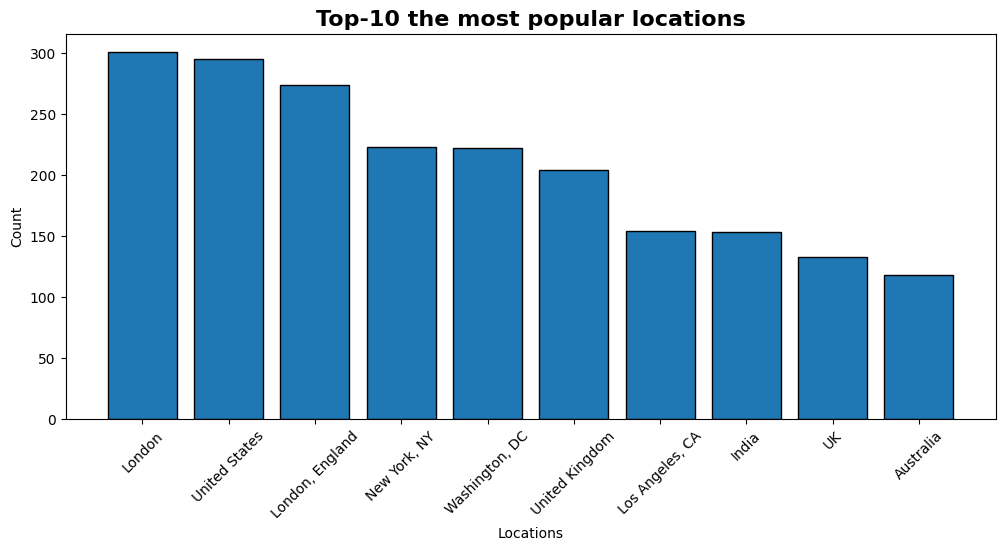

In [ ]:
top10 = train['Location'].value_counts()[1:11]
plt.figure(figsize = (12,5))
plt.bar(top10.index, top10.values, edgecolor='black')
plt.xticks(rotation = 45)
plt.title ('Top-10 the most popular locations', fontweight = 'bold', fontsize = 16)
plt.ylabel ('Count')
plt.xlabel ('Locations')
plt.show()

**Вывод:** Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создадим новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK) Построем аналогичную гистограмму.

In [ ]:
train ['WiderLocation']  = train['Location'].apply(lambda x: x.split(',')[-1].strip())
test ['WiderLocation']  = test['Location'].apply(lambda x: x.split(',')[-1].strip())
train ['WiderLocation'].nunique()

4631

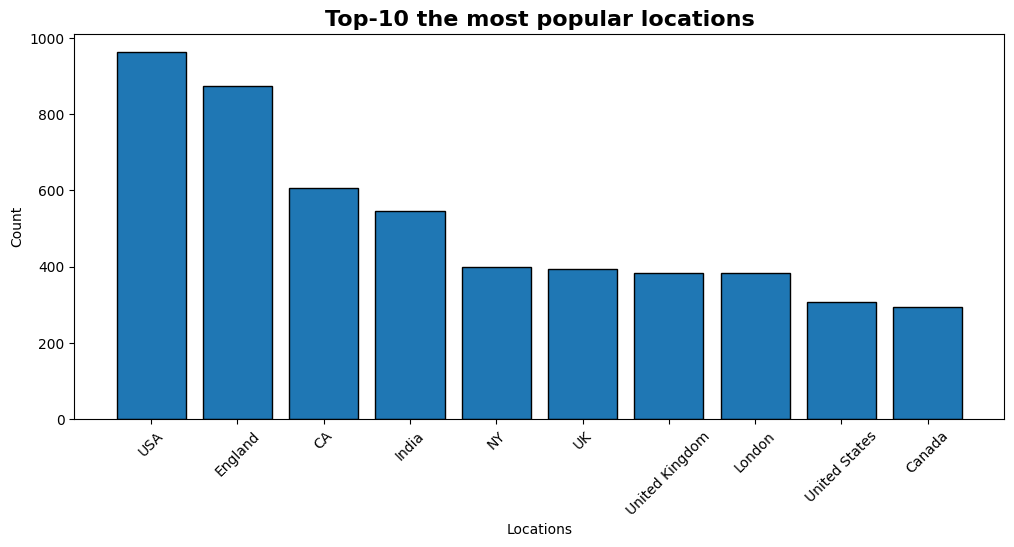

In [ ]:
top10 = train['WiderLocation'].value_counts()[1:11]
plt.figure(figsize = (12,5))
plt.bar(top10.index, top10.values, edgecolor='black')
plt.xticks(rotation = 45)
plt.title ('Top-10 the most popular locations', fontweight = 'bold', fontsize = 16)
plt.ylabel ('Count')
plt.xlabel ('Locations')
plt.show()

Закодируем признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза.


In [ ]:
loc = train['WiderLocation'].value_counts()[train['WiderLocation'].value_counts() > 1].index
loc.nunique()

988

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(loc.values.reshape(-1, 1))
encoded_loc = encoder.transform(train[['WiderLocation']].values.reshape(-1, 1))
encoded_loc_array = encoded_loc.toarray()
encoded_loc_df = pd.DataFrame(encoded_loc_array, columns=loc, index=train.index)
encoded_loc_df.shape

(23410, 988)

In [ ]:
encoded_loc_test = encoder.transform(test['WiderLocation'].values.reshape(-1, 1)) # аналогично для теста
encoded_loc_array_test = encoded_loc_test.toarray()
encoded_loc_df_test = pd.DataFrame(encoded_loc_array_test, columns=loc, index=test.index)
encoded_loc_df_test.shape

(10034, 988)

Добавим этот признак к матрице отскалированных текстовых признаков, обучим логистическую регрессию, замерим качество.

In [ ]:
X_train_scaled_loc = np.hstack((cv_train.toarray(), encoded_loc_df))
X_test_scaled_loc = np.hstack((cv_test.toarray(), encoded_loc_df_test))

In [ ]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(X_train_scaled_loc, target_train)
pred_cv = clf.predict(X_test_scaled_loc)
cv_accuracy = accuracy_score(target_test, pred_cv)

pred_cv_train = clf.predict(X_train_scaled_loc)
cv_accuracy_train = accuracy_score(target_train, pred_cv_train)
print (f'CountVectorizer test: {cv_accuracy}')
print (f'CountVectorizer train: {cv_accuracy_train}')

CountVectorizer test: 0.8438309746860674
CountVectorizer train: 0.9431012387868433


**Вывод:** получилось, что качетсво модели немного упало относительно базовой модели, но не так сильно как с *Username*. Скорее всего, признак не очень полезный

### **Итог**: модель, обученная с помощью  векторайзера CountVectorizer, показала наилучшее качество, дополнительные параметры, методы и признаки почти не оказали эффекта.